In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python --version

Python 3.9.16


In [3]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip3 install leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%cd "/content/drive/MyDrive/Bioinformatics in Python/Single cell sequencing"

/content/drive/MyDrive/Bioinformatics in Python/Single cell sequencing


In [6]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write # writing processed data

mkdir: cannot create directory ‘data’: File exists
--2023-04-17 23:45:57--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-04-17 23:45:58--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  37.0MB/s    in 0.2s    

2023-04-17 23:45:5

In [7]:
import pandas as pd
import numpy as np
import scanpy as sc

In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [9]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in data

https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_10x_mtx.html

In [10]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [11]:
adata.var_names_make_unique()

Number of genes * Nunber of cells

In [12]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# Preprocessing

Show the top 20 gene counts amongst all cells

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.highest_expr_genes.html

normalizing counts per cell
    finished (0:00:00)


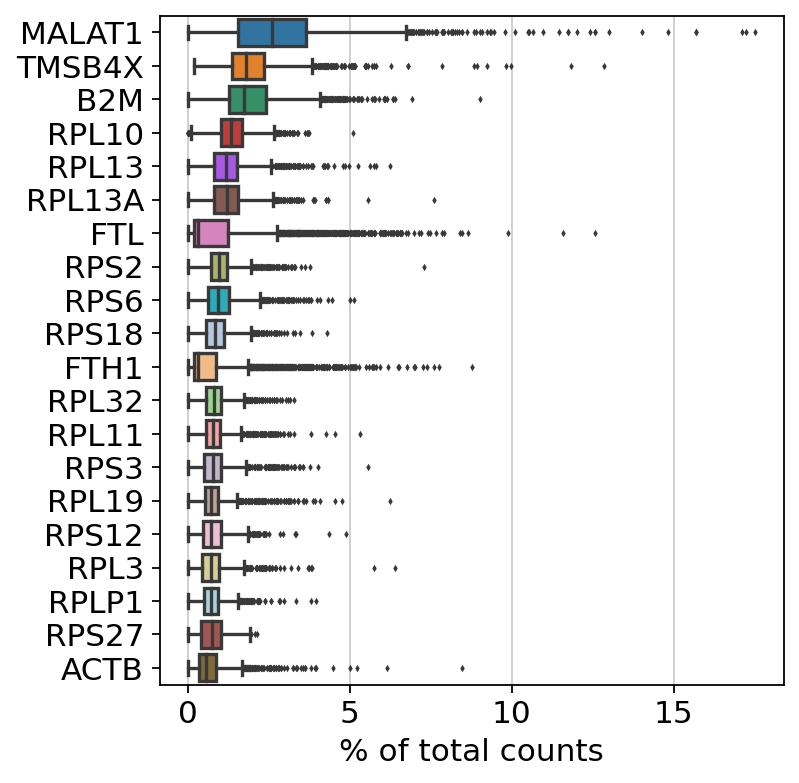

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Filtering

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_cells.html
https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_genes.html

In [14]:
sc.pp.filter_cells(adata, min_genes=200) # filter out cells that have less than 200 genes
sc.pp.filter_genes(adata, min_cells=3) # filter out genes that are detected in less than 3 cells

filtered out 19024 genes that are detected in less than 3 cells


In [15]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [16]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [17]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

Create mitochrondrial column and calculate quality control metrics
https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html

In [18]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # calculate quality control matrics

In [19]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0
...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0


Use violin plot to show the calculate quality control attributes

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.violin.html

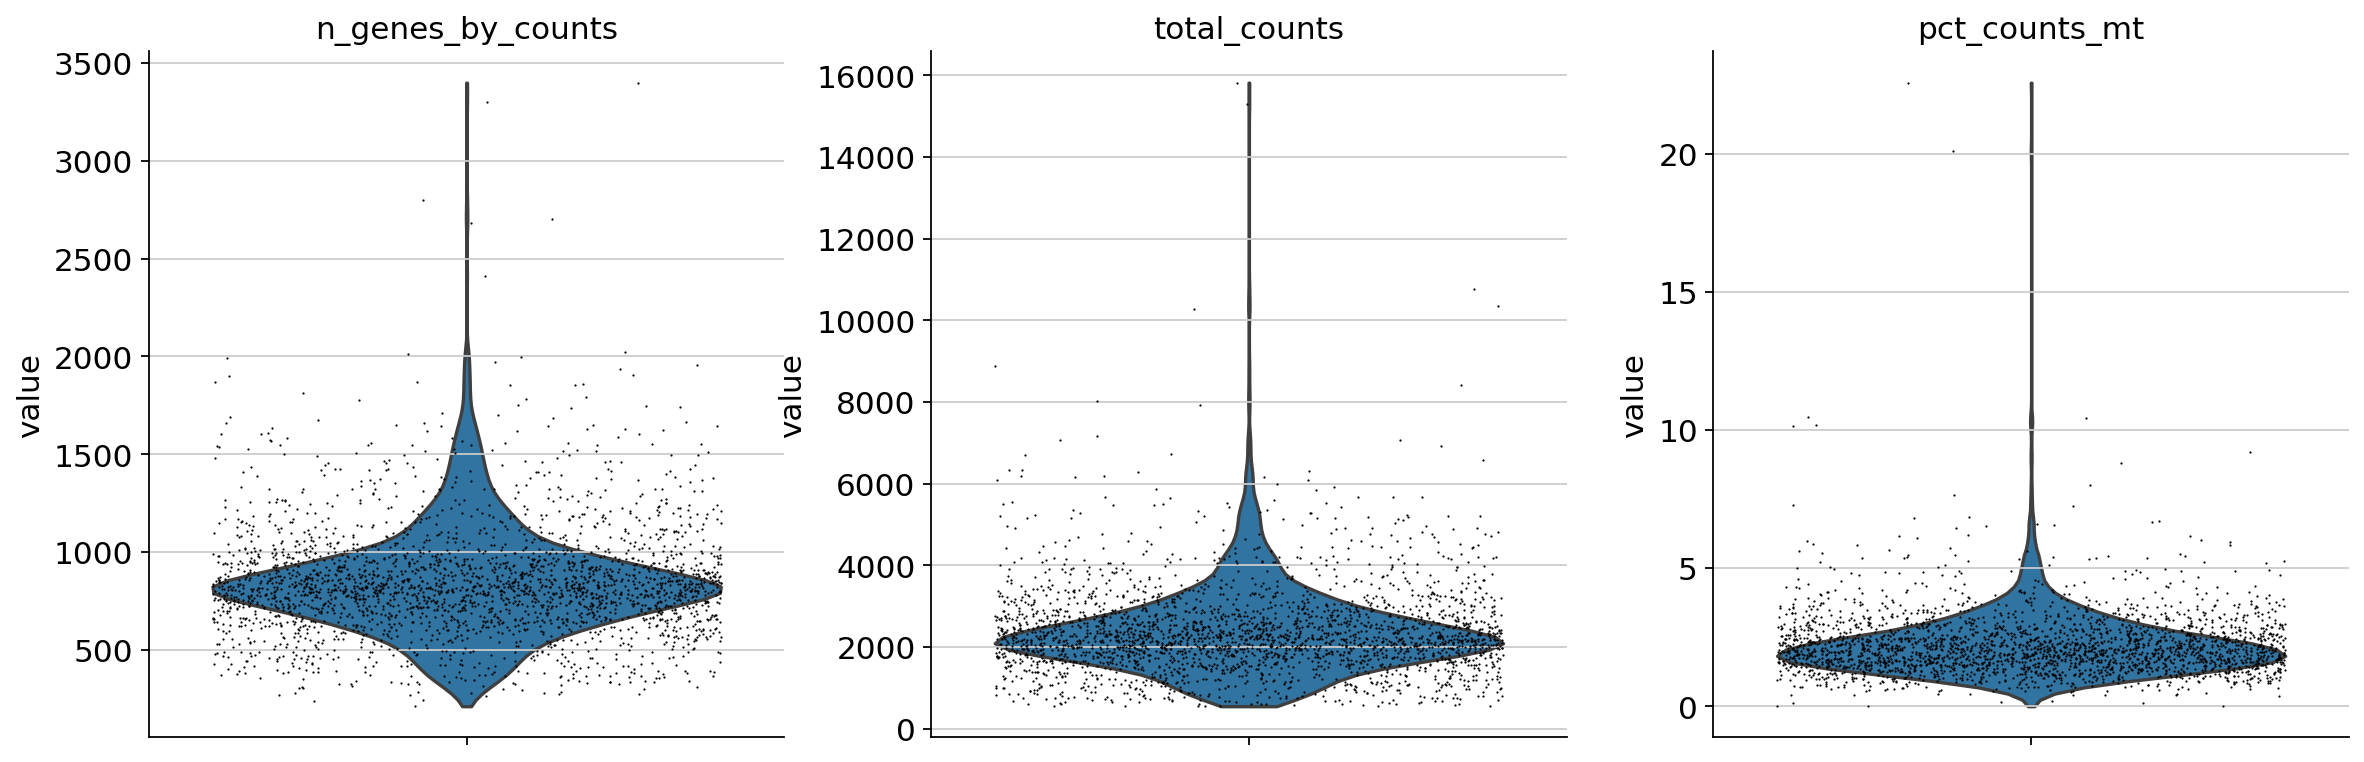

In [20]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:
https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.scatter.html

Before

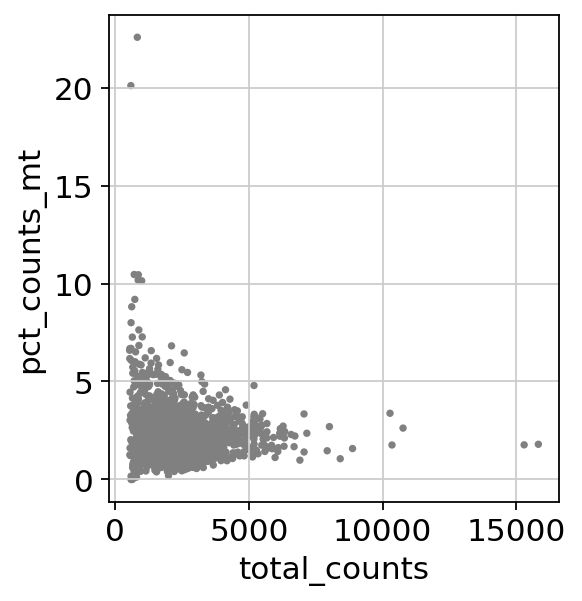

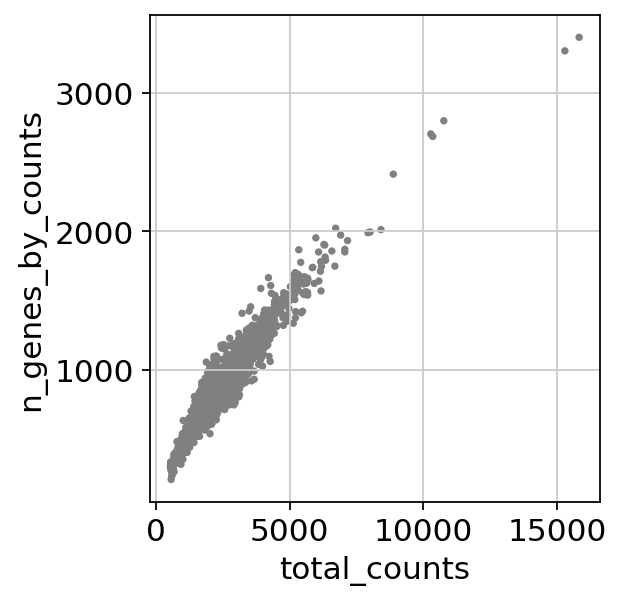

In [21]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Use slicing

In [22]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

After

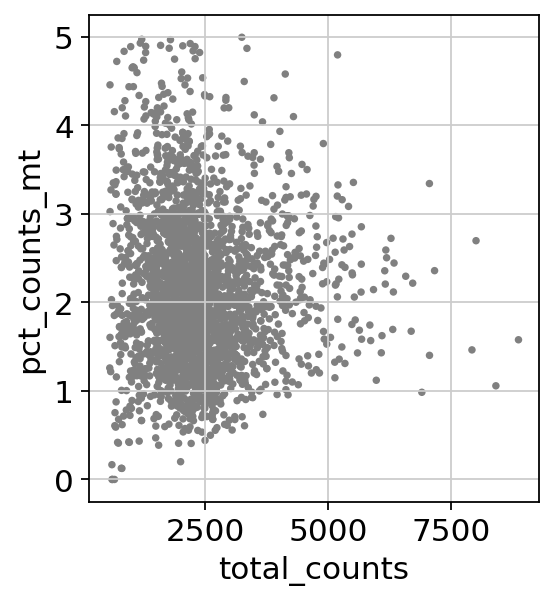

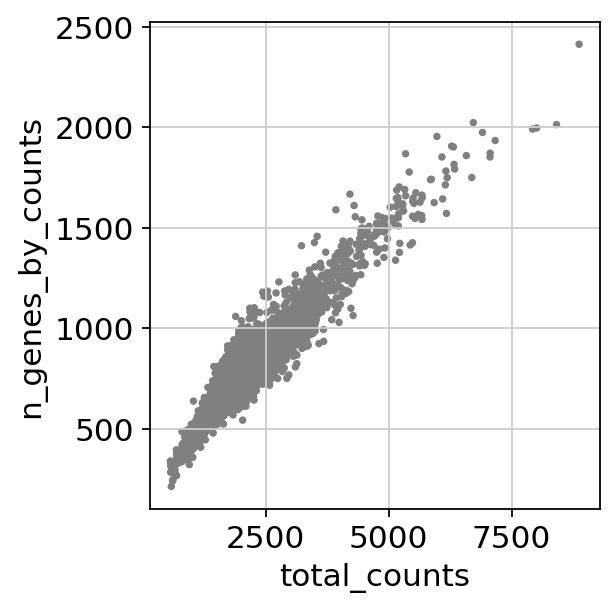

In [23]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Total-count normalize (library-size correct) the data matrix 
 to 10,000 reads per cell, so that counts become comparable among cells.
 https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html

In [25]:
sc.pp.log1p(adata)

Identify highly variable genes

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


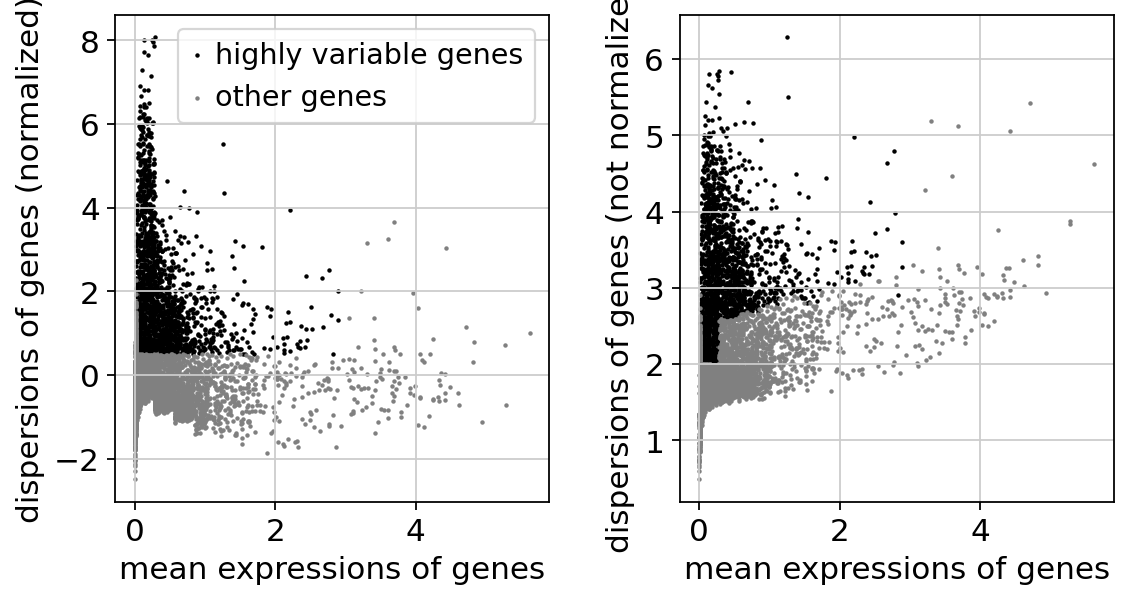

In [27]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [28]:
adata.raw = adata

Actually do the filtering

In [29]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [30]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:13)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [31]:
sc.pp.scale(adata, max_value=10)

# Principle component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.pca.html

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.pca.html

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


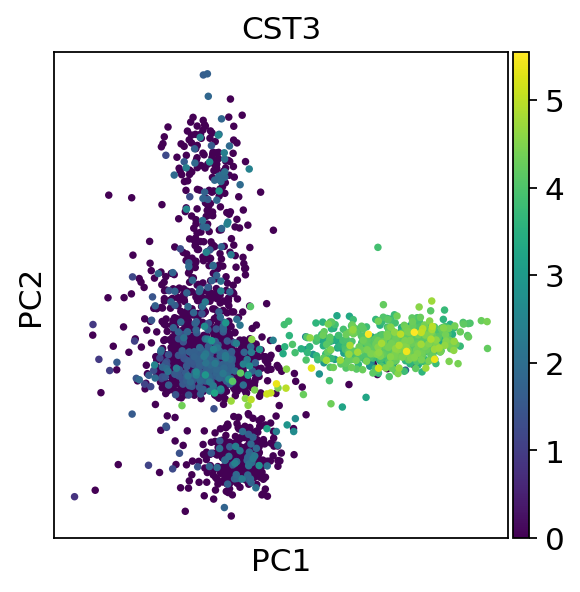

In [33]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.pca_variance_ratio.html

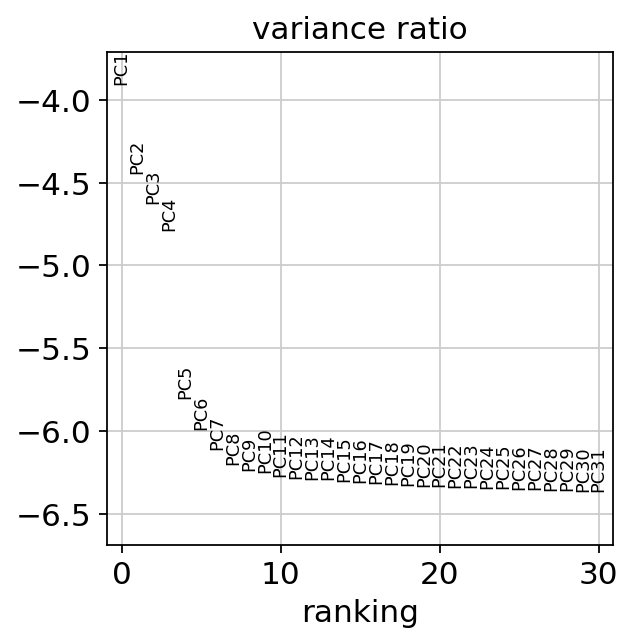

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
adata.write(results_file)

In [36]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html

In [37]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


# Embedding the neighborhood graph

https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.umap.html

In [38]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


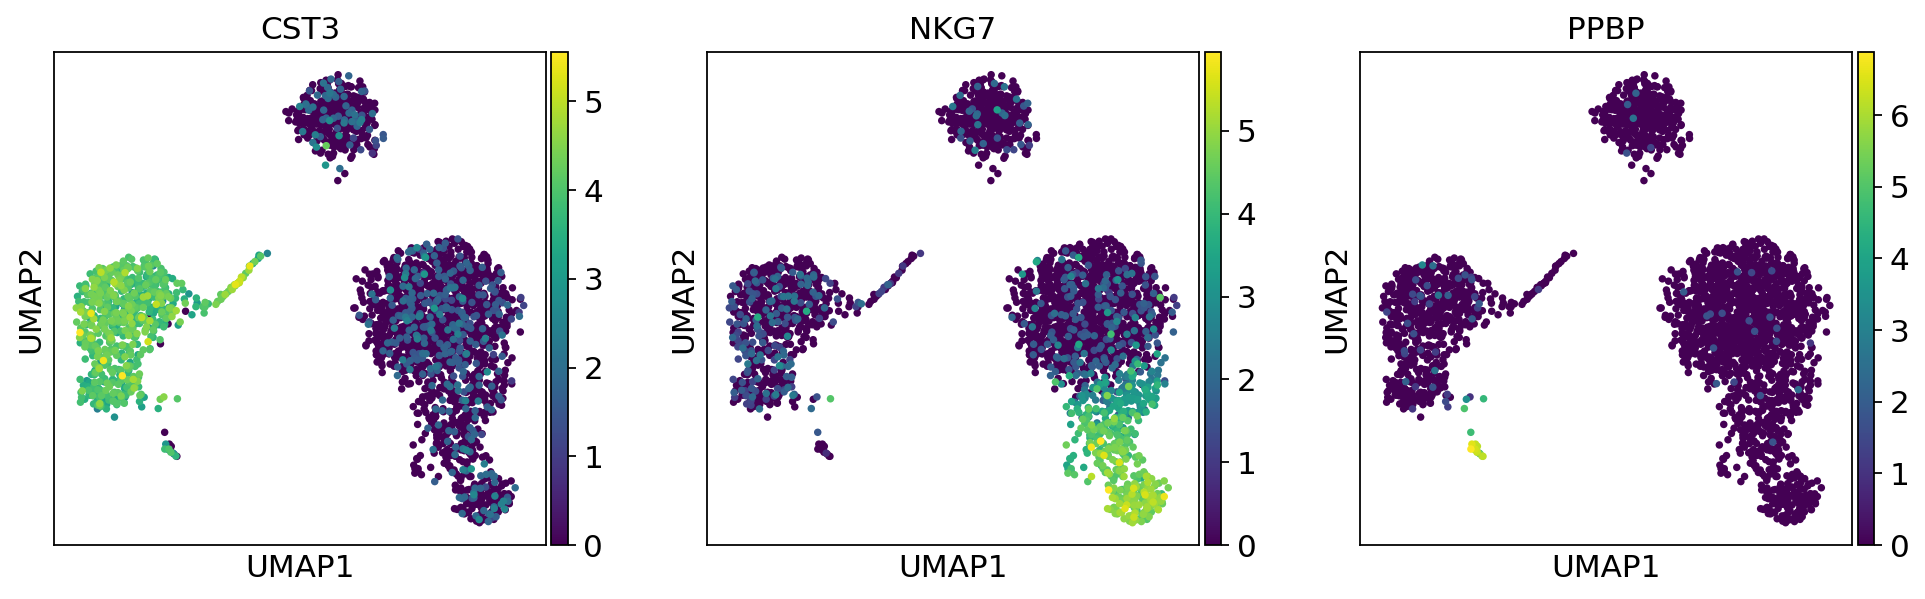

In [39]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

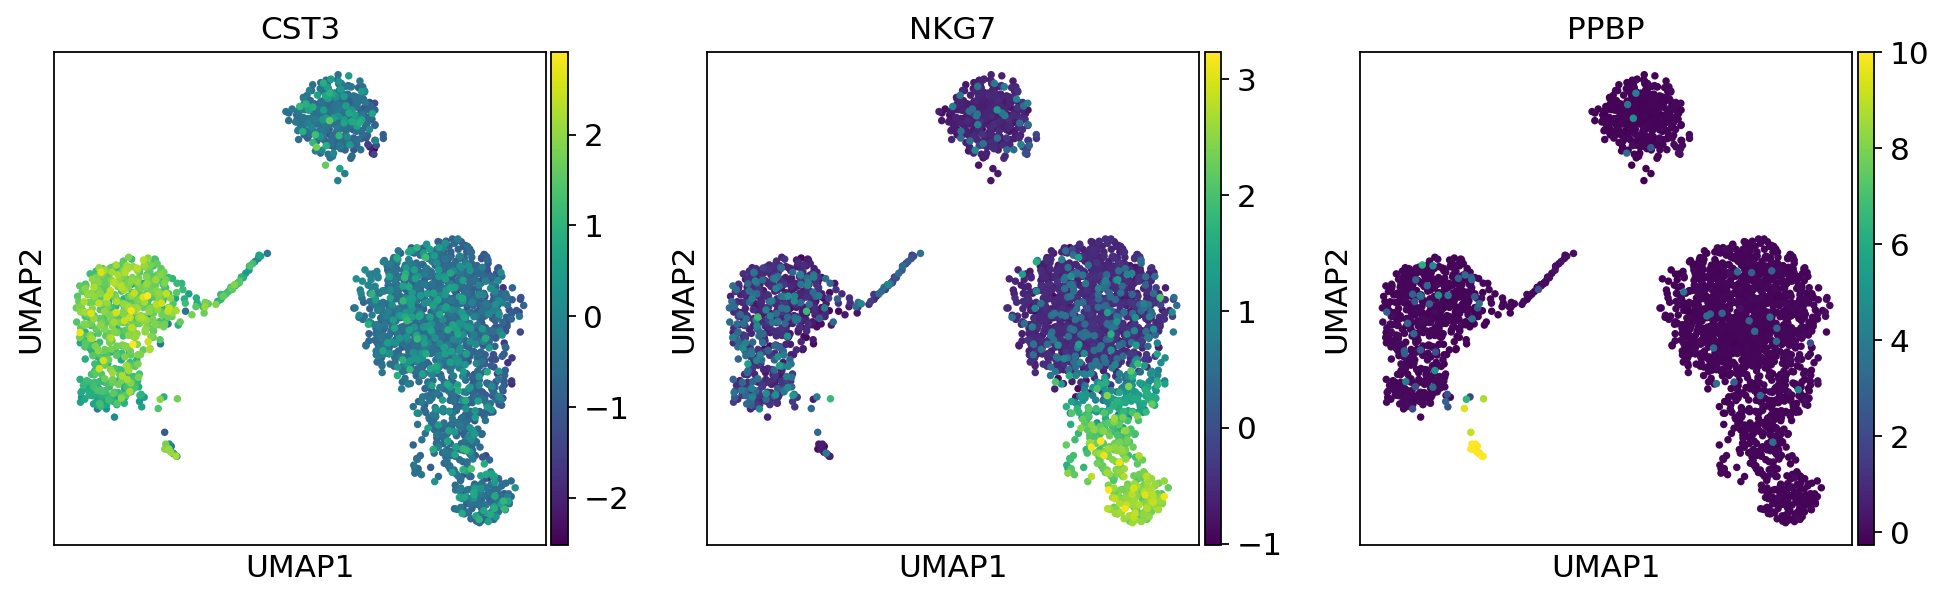

In [40]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering the neighborhood graph

https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html

In [41]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


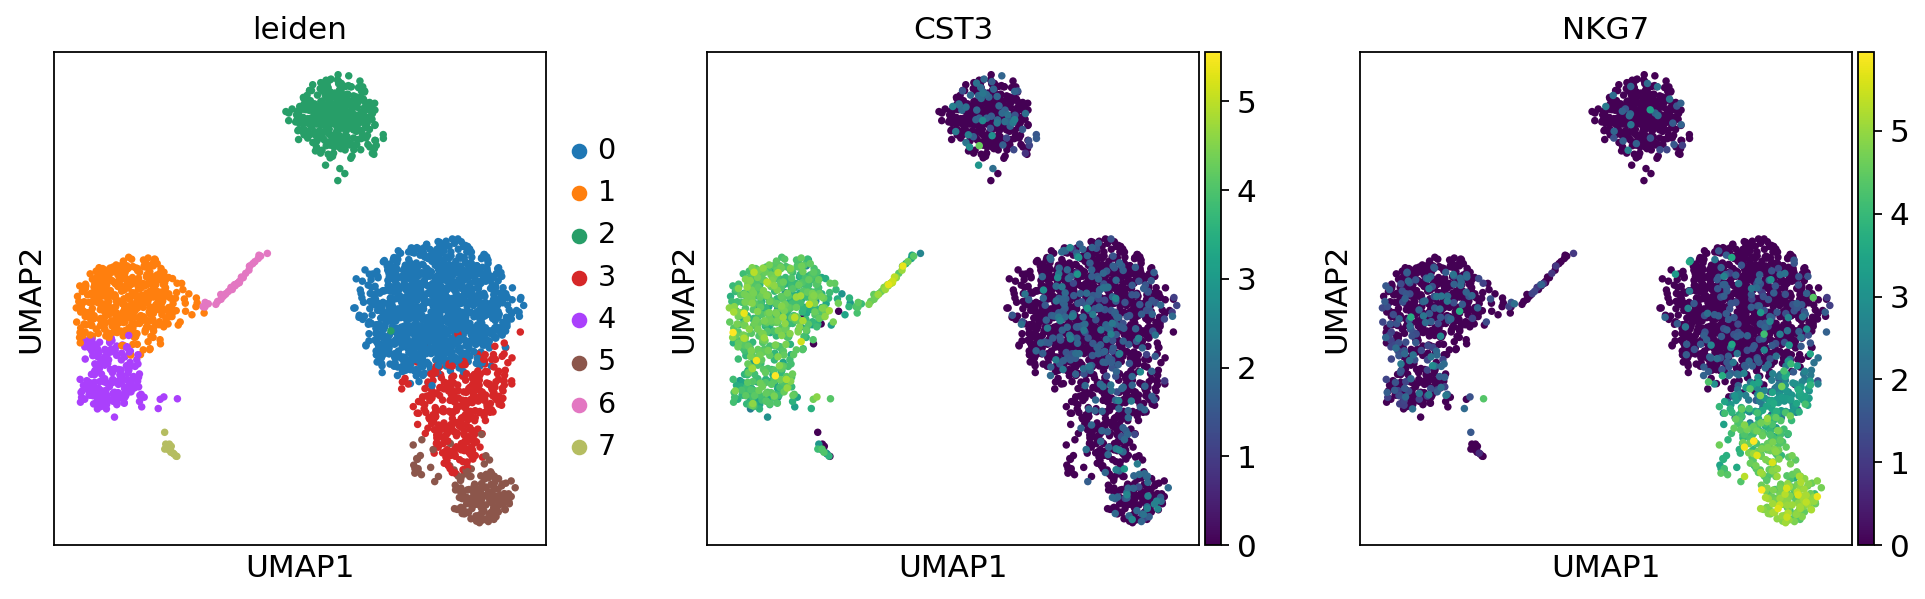

In [42]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [43]:
adata.write(results_file)

# Finding marker genes

https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.rank_genes_groups.html

Using t-test method

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


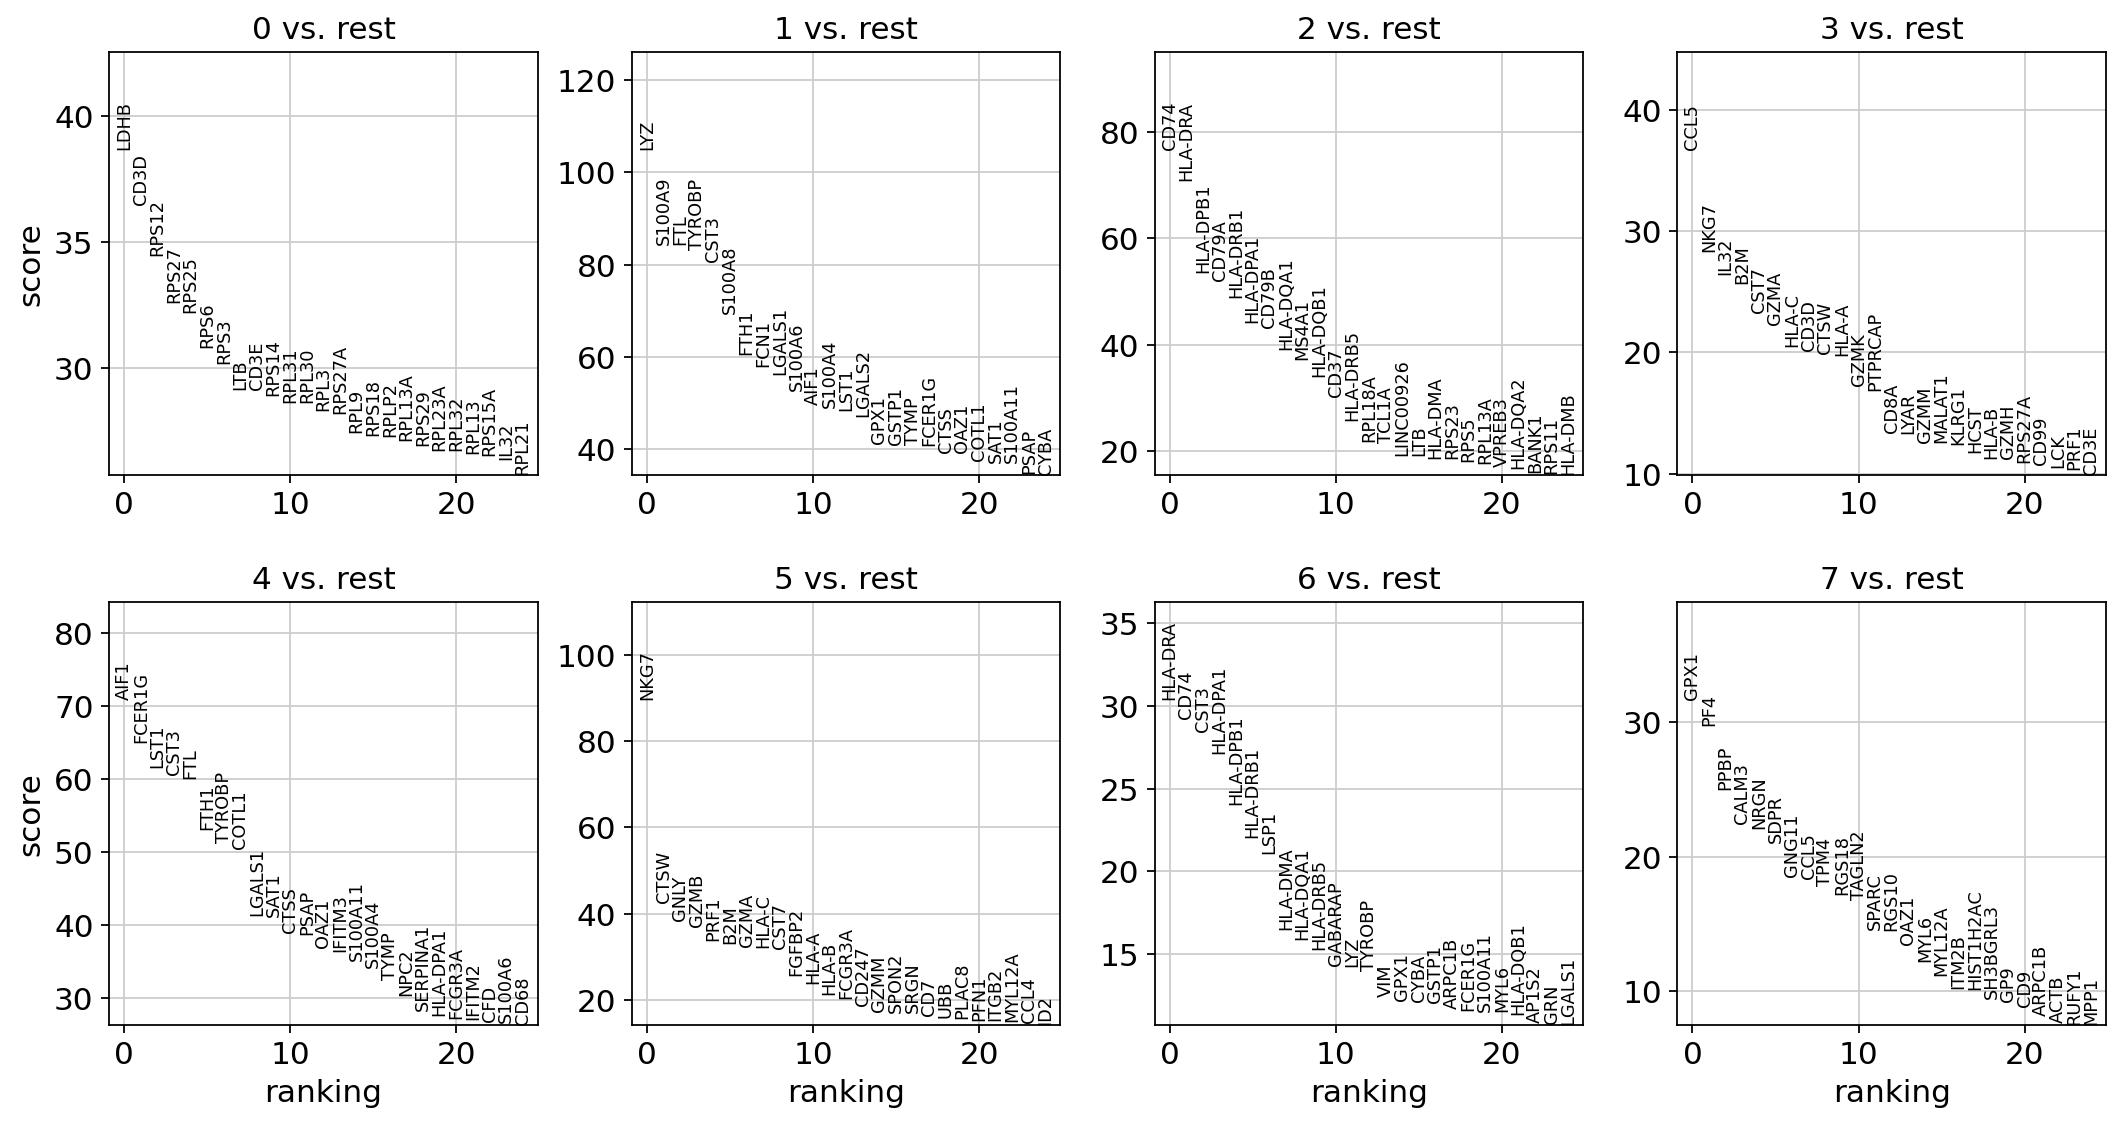

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
sc.settings.verbosity = 2  # reduce the verbosity

Using wilcoxon method

ranking genes
    finished (0:00:02)


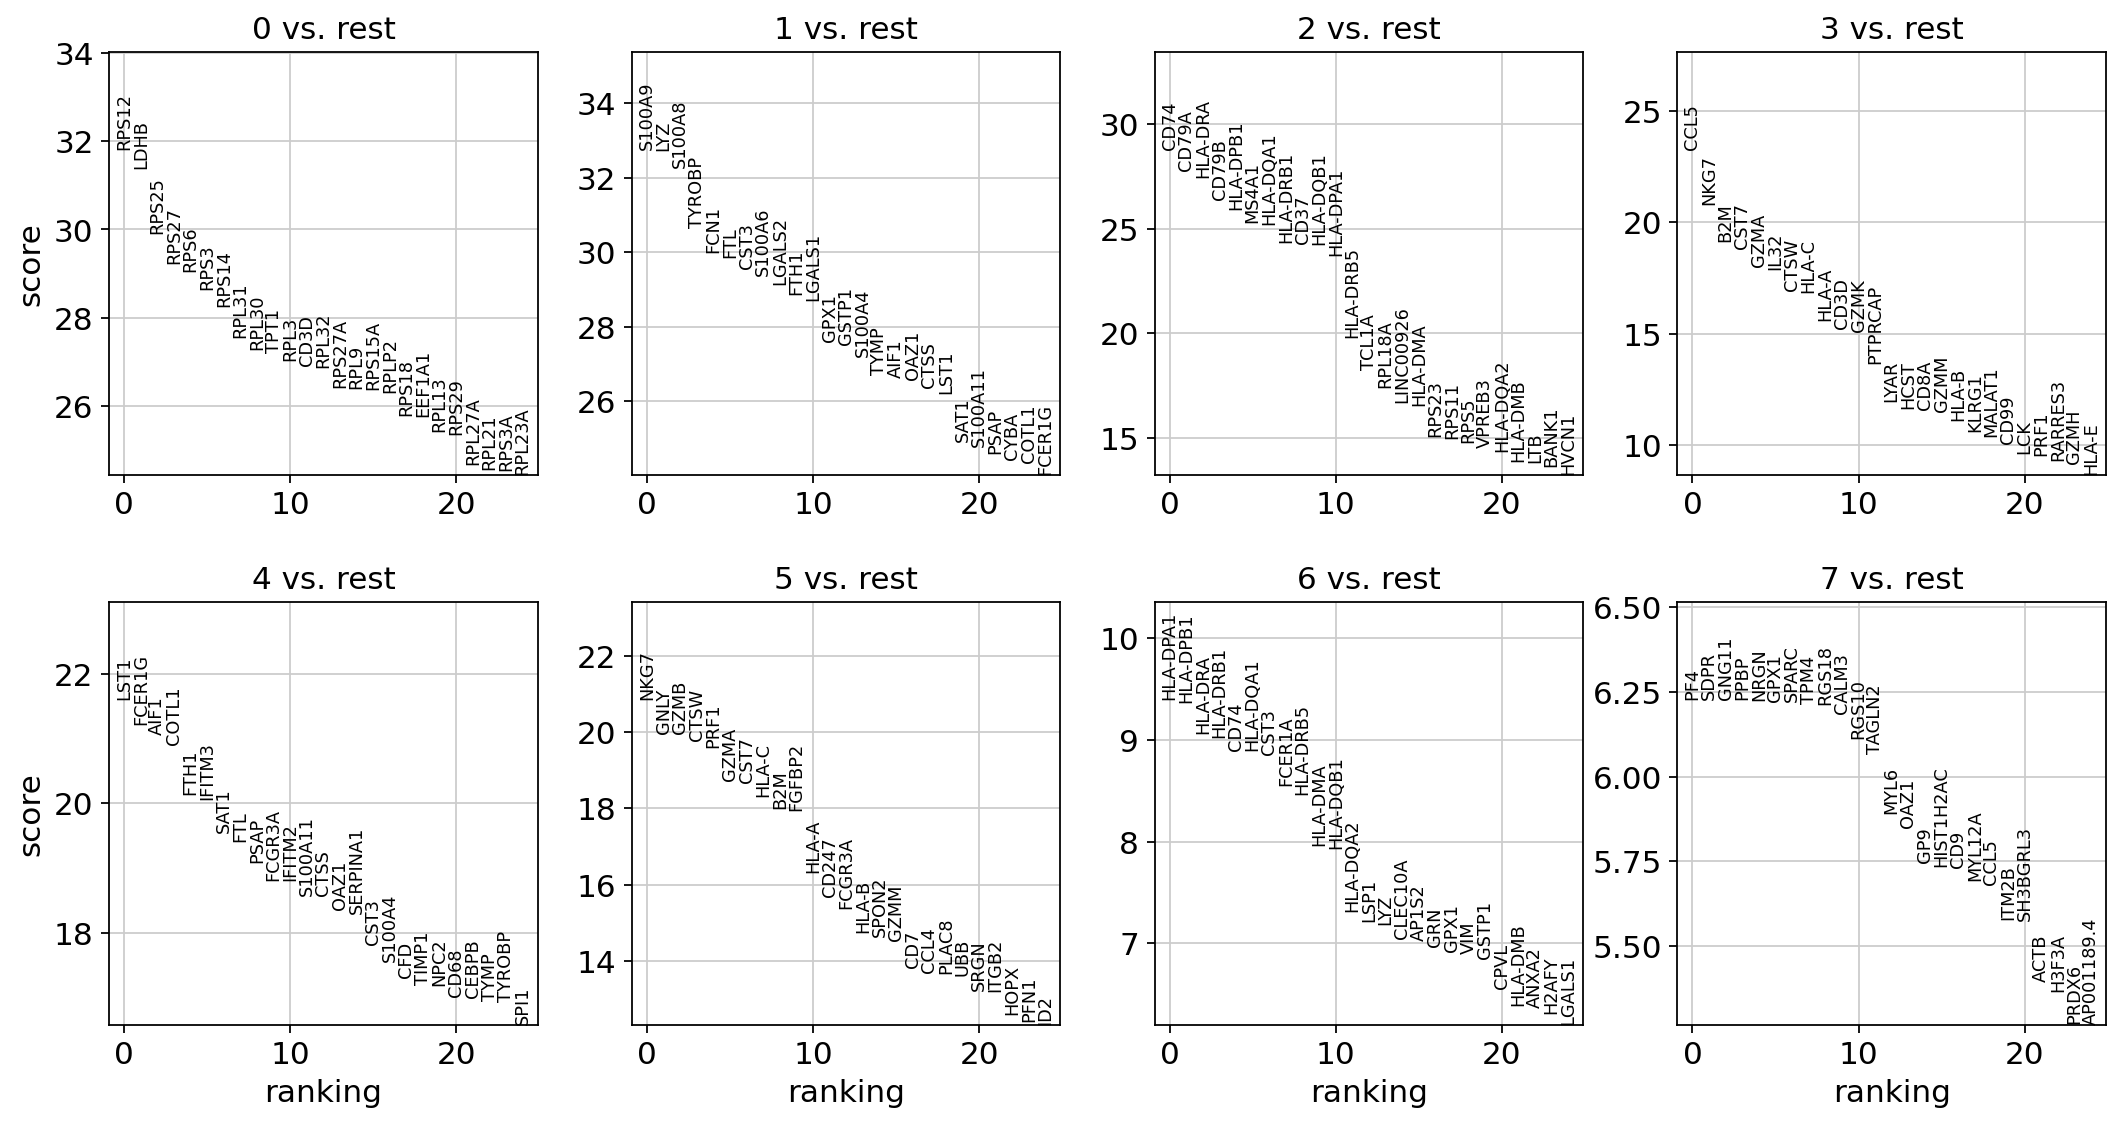

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the wilcoxon rank sum test result

In [47]:
adata.write(results_file)

Using logistic regression

ranking genes
    finished (0:00:15)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


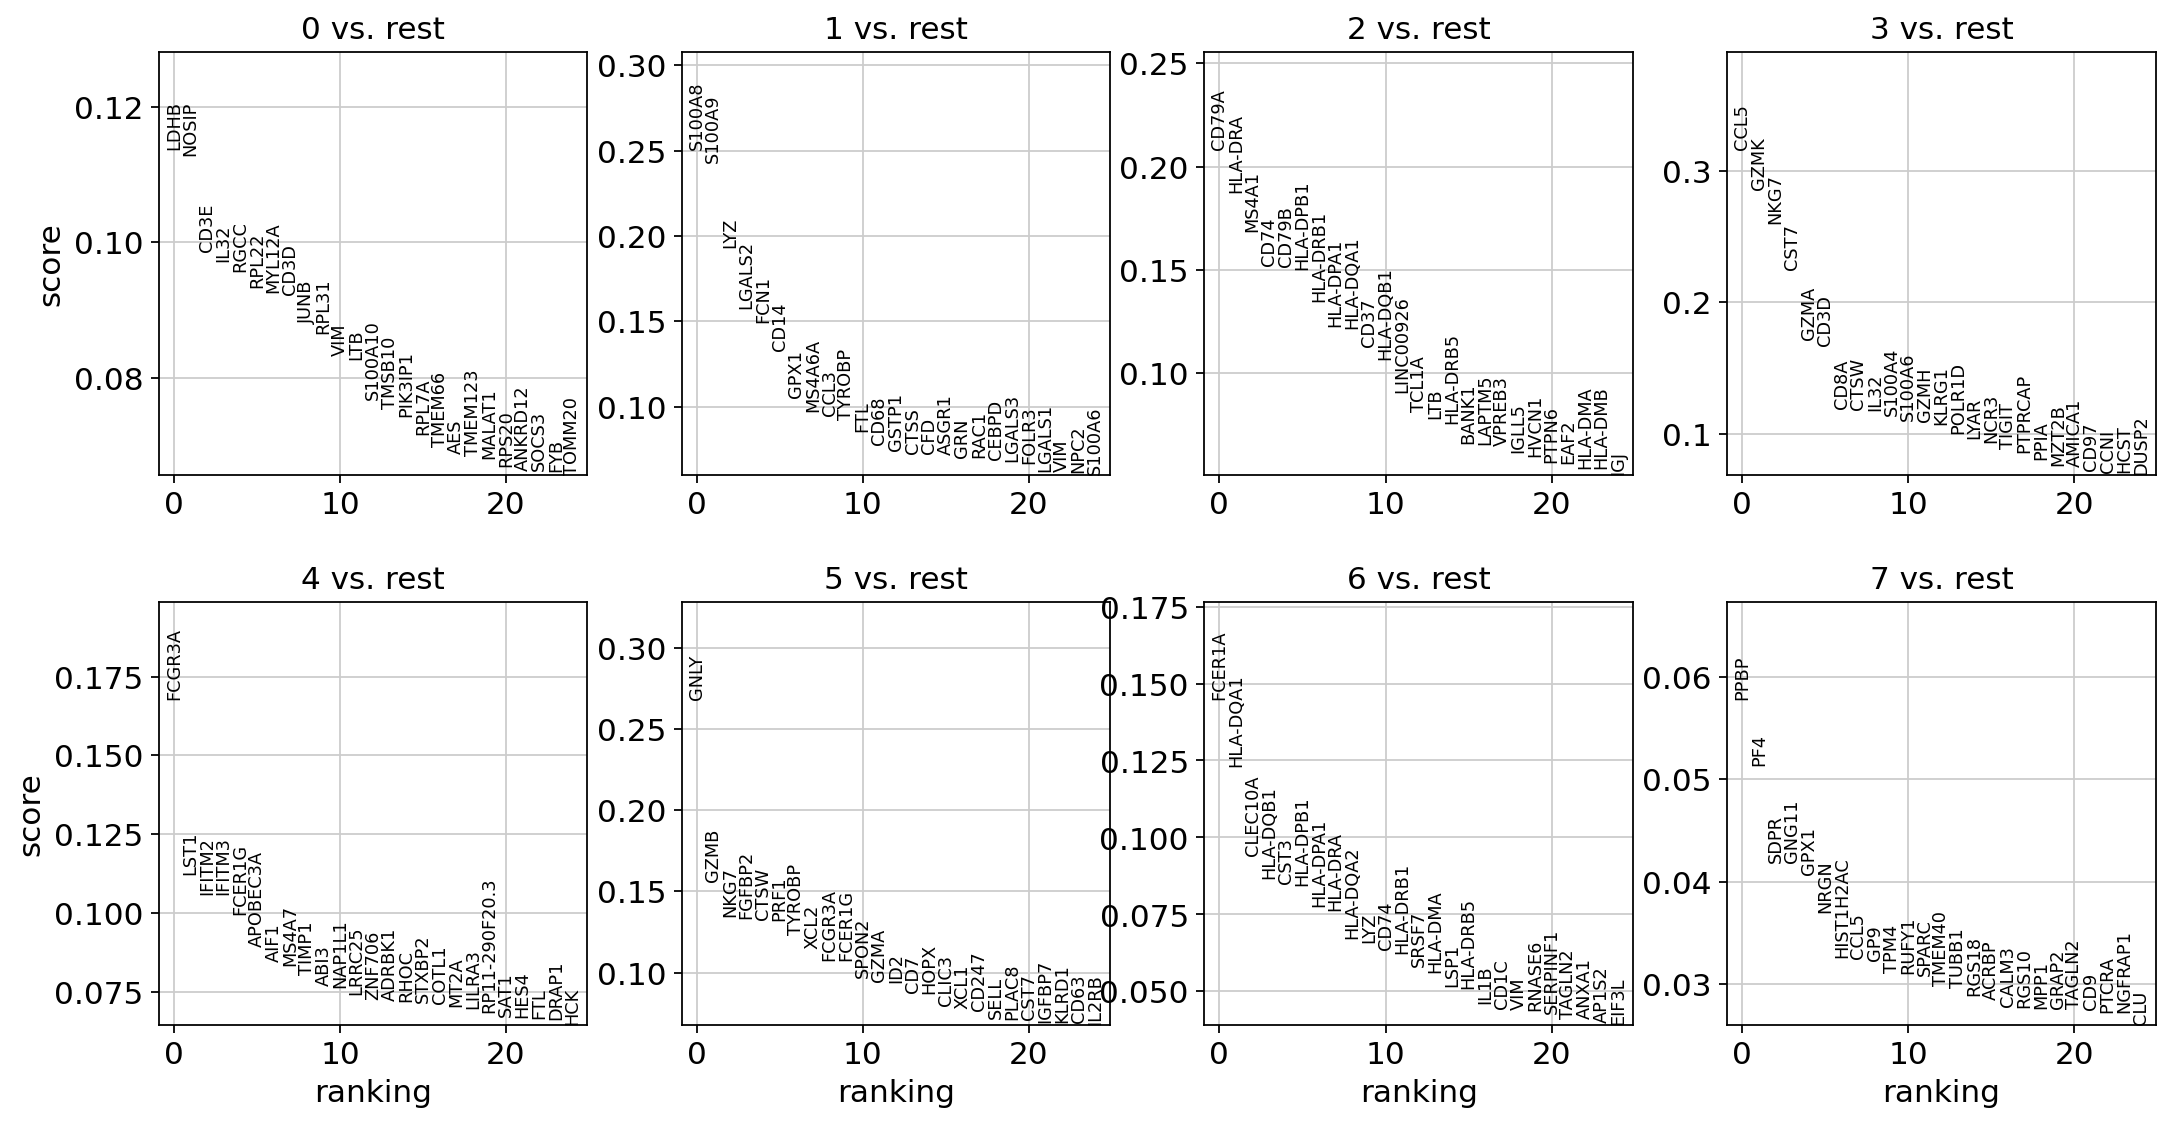

In [48]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [49]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been saved with the wilcoxon rank sum test result

In [50]:
adata = sc.read(results_file)

In [51]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


Create a table with the scores and groups

In [52]:
result = adata.uns["rank_genes_groups"]
result

{'logfoldchanges': array([( 1.0404963,  7.39429  ,  4.0653596 ,  5.1256   ,  5.1597166,  6.8891664,  4.2783146 , 12.905741 ),
        ( 2.6391785,  6.1947355,  7.7365117 ,  4.6366673,  4.8051286,  7.8330994,  4.4348464 , 11.863666 ),
        ( 1.1561569,  7.525499 ,  4.866796  ,  0.7584107,  4.863548 ,  7.6746583,  4.6085496 , 12.428451 ),
        ...,
        (-4.3479757, -1.2199073, -3.1377041 , -1.0713391, -0.9729495, -1.0397398, -0.79307383, -5.350221 ),
        (-2.0639179, -2.0243905, -0.85972863, -0.7450814, -1.0451269, -1.2977405, -0.77232665, -3.9652781),
        (-2.8195815, -1.6044188, -3.8895817 , -0.6358853, -1.231585 , -1.2602488, -1.1790817 , -4.8402567)],
       dtype=[('0', '<f4'), ('1', '<f4'), ('2', '<f4'), ('3', '<f4'), ('4', '<f4'), ('5', '<f4'), ('6', '<f4'), ('7', '<f4')]),
 'names': array([('RPS12', 'S100A9', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'),
        ('LDHB', 'LYZ', 'CD79A', 'NKG7', 'FCER1G', 'GNLY', 'HLA-DPB1', 'SDPR'),
        ('RPS25', 'S100

In [53]:
groups = result["names"].dtype.names
groups

('0', '1', '2', '3', '4', '5', '6', '7')

In [54]:
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.639461e-222,S100A9,1.940467e-235,CD74,3.043536e-182,CCL5,8.082693e-120,LST1,1.620366e-103,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.242464e-216,LYZ,3.649395e-235,CD79A,6.860832e-170,NKG7,4.770586e-96,FCER1G,5.878996e-100,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.395095e-196,S100A8,1.662202e-228,HLA-DRA,8.389292e-166,B2M,1.175554e-81,AIF1,2.004511e-98,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.718451e-188,TYROBP,1.652130e-206,CD79B,1.171444e-153,CST7,6.652244e-79,COTL1,3.853307e-97,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,1.770456e-185,FCN1,1.114817e-197,HLA-DPB1,6.167786e-148,GZMA,1.300917e-72,FTH1,3.651643e-90,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [56]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes


KeyError: ignored